# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [2]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('{}: '.format(k), v.shape)

X_val:  (1000, 3, 32, 32)
y_train:  (49000,)
X_train:  (49000, 3, 32, 32)
y_val:  (1000,)
y_test:  (1000,)
X_test:  (1000, 3, 32, 32)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [4]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print(
    '\nRunning tests with p =', p,
    '\nMean of input:', x.mean(),
    '\nMean of train-time output:', out.mean(),
    '\nMean of test-time output:', out_test.mean(),
    '\nFraction of train-time output set to zero:', (out == 0).mean(),
    '\nFraction of test-time output set to zero:', (out_test == 0).mean())
    print()


Running tests with p = 0.3 
Mean of input: 10.0009045513 
Mean of train-time output: 23.3225201846 
Mean of test-time output: 10.0009045513 
Fraction of train-time output set to zero: 0.300288 
Fraction of test-time output set to zero: 0.0


Running tests with p = 0.6 
Mean of input: 10.0009045513 
Mean of train-time output: 6.66835920616 
Mean of test-time output: 10.0009045513 
Fraction of train-time output set to zero: 0.599876 
Fraction of test-time output set to zero: 0.0


Running tests with p = 0.75 
Mean of input: 10.0009045513 
Mean of train-time output: 3.33544296309 
Mean of test-time output: 10.0009045513 
Fraction of train-time output set to zero: 0.749924 
Fraction of test-time output set to zero: 0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [5]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  0.111111111092


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [18]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.30304316117
W0 relative error: 4.79519686598774e-07
W1 relative error: 1.9717710509245953e-07
W2 relative error: 1.5587099207249475e-07
b0 relative error: 2.0336159579565187e-08
b1 relative error: 1.6863157228196606e-09
b2 relative error: 1.1144421861081857e-10

Running check with dropout =  0.25
Initial loss:  2.33301403728
W0 relative error: 0.8823529418978798
W1 relative error: 0.6000000054107255
W2 relative error: 2.539779845436568e-08
b0 relative error: 0.8823529412147084
b1 relative error: 0.6000000026747319
b2 relative error: 1.3965346166138227e-10

Running check with dropout =  0.5
Initial loss:  2.29944002906
W0 relative error: 0.6000000200169119
W1 relative error: 0.3333333952759486
W2 relative error: 2.3767592670693847e-08
b0 relative error: 0.6000000006358542
b1 relative error: 0.3333333338338768
b2 relative error: 1.4333807510530193e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [20]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 0 / 125) loss: 8.5962
(Epoch 0.00 / 25.00) train acc: 22.40%; val_acc: 18.30%


C:\users\joshu\documents\cs231n\assignment2\cs231n\layers.py:588: RuntimeWarning: divide by zero encountered in log
  N = x.shape[0]


(Epoch 1.00 / 25.00) train acc: 38.20%; val_acc: 21.90%
(Epoch 2.00 / 25.00) train acc: 48.40%; val_acc: 24.80%
(Epoch 3.00 / 25.00) train acc: 62.00%; val_acc: 27.40%
(Epoch 4.00 / 25.00) train acc: 64.80%; val_acc: 24.60%
(Epoch 5.00 / 25.00) train acc: 72.40%; val_acc: 28.10%
(Epoch 6.00 / 25.00) train acc: 78.40%; val_acc: 30.20%
(Epoch 7.00 / 25.00) train acc: 82.20%; val_acc: 25.90%
(Epoch 8.00 / 25.00) train acc: 84.00%; val_acc: 27.10%
(Epoch 9.00 / 25.00) train acc: 89.20%; val_acc: 28.50%
(Epoch 10.00 / 25.00) train acc: 91.40%; val_acc: 29.40%
(Epoch 11.00 / 25.00) train acc: 95.40%; val_acc: 27.10%
(Epoch 12.00 / 25.00) train acc: 95.00%; val_acc: 27.30%
(Epoch 13.00 / 25.00) train acc: 96.60%; val_acc: 29.00%
(Epoch 14.00 / 25.00) train acc: 97.60%; val_acc: 29.70%
(Epoch 15.00 / 25.00) train acc: 98.40%; val_acc: 30.30%
(Epoch 16.00 / 25.00) train acc: 97.40%; val_acc: 28.00%
(Epoch 17.00 / 25.00) train acc: 98.40%; val_acc: 28.10%
(Epoch 18.00 / 25.00) train acc: 98.00%;

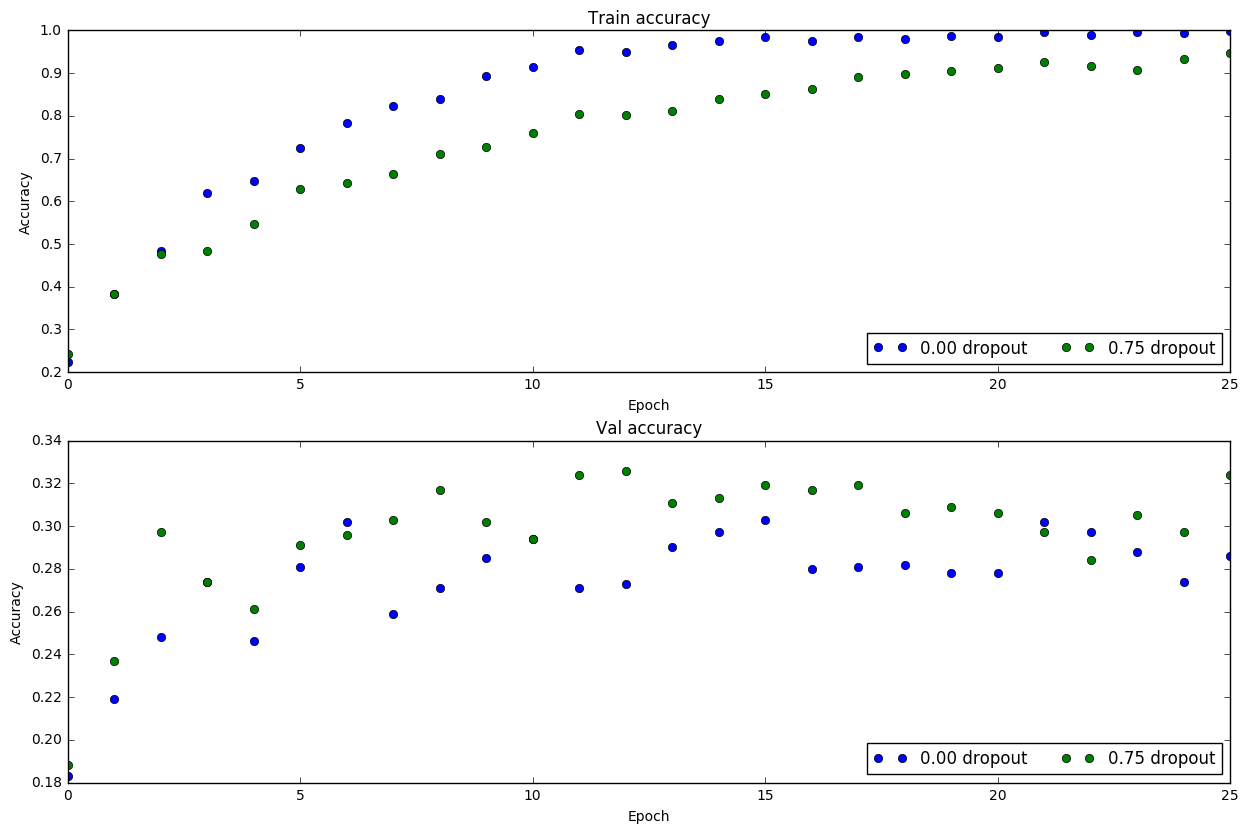

In [21]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Explain what you see in this experiment. What does it suggest about dropout?

# Answer
It seems like Dropout slows down the training of the model, and perhaps reduces overall accuracy. However, it does improve generalization to a validation set. Perhaps Dropout reduces overfitting of the model, which has a regularizing effect.